In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.saving import register_keras_serializable
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import math
import random
import time # To time data processing
import warnings
warnings.filterwarnings('ignore')

In [2]:
# --- Paths ---
RAW_DATA_PATH = '../data/raw/GTZAN/genres_original' # Adjust path to GTZAN 'genres_original'
MODEL_SAVE_DIR = '../model'
BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'best_chunked_custom_cnn_model.keras')

In [3]:
# --- Audio & Chunking Parameters ---
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # Expected duration of original tracks
CHUNK_DURATION_S = 4 # Duration of chunks in seconds
CHUNK_OVERLAP_S = 2  # Overlap duration in seconds
SAMPLES_PER_CHUNK = int(CHUNK_DURATION_S * SAMPLE_RATE)
HOP_SAMPLES_BETWEEN_CHUNKS = int((CHUNK_DURATION_S - CHUNK_OVERLAP_S) * SAMPLE_RATE)

In [4]:
# --- Spectrogram Parameters ---
N_MELS = 128   # Number of Mel bands
N_FFT = 2048   # Window size for FFT
HOP_LENGTH = 512 # Hop length for STFT

In [5]:
# --- Resizing Parameters ---
# Resize spectrogram chunks to a square shape
RESIZE_DIM = 128 # Target height and width (e.g., 128x128)
TARGET_SHAPE = (RESIZE_DIM, RESIZE_DIM)

In [6]:
# --- Genre Classes ---
GENRES = sorted([
    'blues', 'classical', 'country', 'disco', 'hiphop',
    'jazz', 'metal', 'pop', 'reggae', 'rock'
])
NUM_GENRES = len(GENRES)


In [7]:
# --- Augmentation Parameters ---
FREQ_MASK_PARAM = 25
TIME_MASK_PARAM = 30 # Adjusted for potentially shorter time dim after resize


In [8]:
# --- Training Parameters ---
EPOCHS = 150
BATCH_SIZE = 32
LEARNING_RATE = 1e-4

In [9]:
# --- Reproducibility ---
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [10]:
# --- Create Model Save Directory ---
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

In [11]:
def compute_mel_spectrogram(audio, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    """Computes the Mel spectrogram and converts it to dB scale."""
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

def resize_spectrogram_tf(spec, target_shape=TARGET_SHAPE):
    """Resizes spectrogram using TensorFlow."""
    # Add channel dim, resize, remove channel dim
    spec_tf = tf.constant(spec[..., np.newaxis], dtype=tf.float32)
    resized_spec_tf = tf.image.resize(spec_tf, target_shape, method='bilinear')
    return resized_spec_tf.numpy().squeeze() # Back to numpy array (H, W)

def load_chunk_process_data(data_path, genres_list, sr=SAMPLE_RATE,
                            chunk_samples=SAMPLES_PER_CHUNK,
                            hop_between_chunks=HOP_SAMPLES_BETWEEN_CHUNKS,
                            target_shape=TARGET_SHAPE):
    """Loads audio, creates overlapping chunks, computes, resizes Mel spectrograms."""
    all_spectrograms = []
    all_labels = []
    start_time = time.time()

    print("Starting data loading, chunking, and processing...")
    for genre_idx, genre in enumerate(genres_list):
        genre_path = os.path.join(data_path, genre)
        if not os.path.exists(genre_path):
            print(f"Warning: Path not found {genre_path}. Skipping genre.")
            continue

        print(f"Processing {genre} files...")
        files_processed_count = 0
        chunks_generated_count = 0
        for filename in os.listdir(genre_path):
            if filename.lower().endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                try:
                    # Load the full audio file
                    audio_data, current_sr = librosa.load(file_path, sr=sr, mono=True)

                    # Calculate number of chunks for this file
                    if len(audio_data) < chunk_samples:
                        print(f"  Skipping short file: {filename} (length {len(audio_data)} < {chunk_samples})")
                        continue # Skip files shorter than one chunk

                    num_chunks = int(np.floor((len(audio_data) - chunk_samples) / hop_between_chunks)) + 1

                    # Generate chunks and process
                    for i in range(num_chunks):
                        start_sample = i * hop_between_chunks
                        end_sample = start_sample + chunk_samples
                        chunk = audio_data[start_sample:end_sample]

                        # Ensure chunk is exactly chunk_samples long (handle end cases)
                        if len(chunk) == chunk_samples:
                            # Compute Mel spectrogram
                            mel_spec_db = compute_mel_spectrogram(chunk, sr=current_sr) # Uses global params

                            # Resize spectrogram chunk
                            resized_spec = resize_spectrogram_tf(mel_spec_db, target_shape)

                            # Append data
                            all_spectrograms.append(resized_spec)
                            all_labels.append(genre_idx)
                            chunks_generated_count += 1

                    files_processed_count += 1

                except Exception as e:
                    print(f"  Error processing file {file_path}: {e}")
        print(f" -> Processed {files_processed_count} files, generated {chunks_generated_count} chunks for {genre}.")

    end_time = time.time()
    print(f"Data loading and processing finished in {end_time - start_time:.2f} seconds.")

    if not all_spectrograms:
        raise ValueError("No spectrograms were generated. Check paths and audio files.")

    return np.array(all_spectrograms), np.array(all_labels)

In [12]:
# --- Execute Data Processing ---
# This might take some time depending on your CPU/disk speed
X_chunks_raw, y_chunks_raw = load_chunk_process_data(RAW_DATA_PATH, GENRES)

print(f"\nTotal spectrogram chunks generated: {len(X_chunks_raw)}")
if len(X_chunks_raw) > 0:
    print(f"Shape of first chunk spectrogram: {X_chunks_raw[0].shape}") # Should be TARGET_SHAPE
else:
     raise ValueError("Chunk list is empty after processing.")

Starting data loading, chunking, and processing...
Processing blues files...
 -> Processed 100 files, generated 1400 chunks for blues.
Processing classical files...
 -> Processed 100 files, generated 1398 chunks for classical.
Processing country files...
 -> Processed 100 files, generated 1397 chunks for country.
Processing disco files...
 -> Processed 100 files, generated 1399 chunks for disco.
Processing hiphop files...
 -> Processed 100 files, generated 1398 chunks for hiphop.
Processing jazz files...
  Error processing file ../data/raw/GTZAN/genres_original/jazz/jazz.00054.wav: 
 -> Processed 99 files, generated 1386 chunks for jazz.
Processing metal files...
 -> Processed 100 files, generated 1400 chunks for metal.
Processing pop files...
 -> Processed 100 files, generated 1400 chunks for pop.
Processing reggae files...
 -> Processed 100 files, generated 1400 chunks for reggae.
Processing rock files...
 -> Processed 100 files, generated 1399 chunks for rock.
Data loading and proce

In [13]:
# ## 4. Prepare Chunked Data for Training

print("\nPreparing chunked data for training...")

# --- Add Channel Dimension ---
# Input shape should be (num_chunks, height, width)
if X_chunks_raw.ndim == 3:
    X = X_chunks_raw[..., np.newaxis]
    print(f"Data shape after adding channel: {X.shape}") # (num_chunks, H, W, 1)
else:
    raise ValueError(f"Unexpected spectrogram array dimension: {X_chunks_raw.ndim}. Expected 3.")


Preparing chunked data for training...
Data shape after adding channel: (13977, 128, 128, 1)


In [14]:
# --- Encode Labels ---
y = to_categorical(y_chunks_raw, num_classes=NUM_GENRES)
print(f"Labels shape after one-hot encoding: {y.shape}")

Labels shape after one-hot encoding: (13977, 10)


In [15]:
# --- Train/Validation/Test Split ---
# Split into Train (80%) and Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
# Split Train into Train (64% total) and Validation (16% total)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

print(f"Training set shape:   {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Testing set shape:    {X_test.shape}, {y_test.shape}")

Training set shape:   (8944, 128, 128, 1), (8944, 10)
Validation set shape: (2237, 128, 128, 1), (2237, 10)
Testing set shape:    (2796, 128, 128, 1), (2796, 10)


In [17]:
 #--- Global Normalization (Min-Max Scaling on Chunks) ---
print("Applying global Min-Max normalization...")
scaler = MinMaxScaler()

# Reshape for scaler
original_train_shape = X_train.shape
original_val_shape = X_val.shape
original_test_shape = X_test.shape

X_train_reshaped = X_train.reshape(original_train_shape[0], -1)
X_val_reshaped = X_val.reshape(original_val_shape[0], -1)
X_test_reshaped = X_test.reshape(original_test_shape[0], -1)

# Fit scaler ONLY on training data
scaler.fit(X_train_reshaped)

# Transform all datasets
X_train = scaler.transform(X_train_reshaped).reshape(original_train_shape)
X_val = scaler.transform(X_val_reshaped).reshape(original_val_shape)
X_test = scaler.transform(X_test_reshaped).reshape(original_test_shape)

print("Normalization complete.")
print(f"Scaled X_train min: {np.min(X_train):.4f}, max: {np.max(X_train):.4f}")

Applying global Min-Max normalization...
Normalization complete.
Scaled X_train min: 0.0000, max: 1.0000


# ## 7. Train the Model

In [23]:
def build_refined_cnn_model(input_shape, num_genres, l2_reg=0.001):
    """Builds a refined custom CNN model with BatchNorm, GAP, and regularization."""

    model = models.Sequential(name="Refined_CNN_Genre_Classifier")
    model.add(layers.Input(shape=input_shape, name="Input_Spectrogram"))

    # Augmentation
    model.add(FrequencyMasking(FREQ_MASK_PARAM, name="FreqMask"))
    model.add(TimeMasking(TIME_MASK_PARAM, name="TimeMask"))

    # --- Feature Extraction Blocks ---
    # Block 1
    model.add(layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(l2_reg), name="Conv1_1"))
    model.add(layers.BatchNormalization(name="BN1_1"))
    model.add(layers.Activation('relu', name="Relu1_1"))
    model.add(layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(l2_reg), name="Conv1_2"))
    model.add(layers.BatchNormalization(name="BN1_2"))
    model.add(layers.Activation('relu', name="Relu1_2"))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name="Pool1"))
    model.add(layers.Dropout(0.25, name="Drop1"))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(l2_reg), name="Conv2_1"))
    model.add(layers.BatchNormalization(name="BN2_1"))
    model.add(layers.Activation('relu', name="Relu2_1"))
    model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(l2_reg), name="Conv2_2"))
    model.add(layers.BatchNormalization(name="BN2_2"))
    model.add(layers.Activation('relu', name="Relu2_2"))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name="Pool2"))
    model.add(layers.Dropout(0.25, name="Drop2"))

    # Block 3
    model.add(layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(l2_reg), name="Conv3_1"))
    model.add(layers.BatchNormalization(name="BN3_1"))
    model.add(layers.Activation('relu', name="Relu3_1"))
    model.add(layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(l2_reg), name="Conv3_2"))
    model.add(layers.BatchNormalization(name="BN3_2"))
    model.add(layers.Activation('relu', name="Relu3_2"))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name="Pool3"))
    model.add(layers.Dropout(0.3, name="Drop3"))

    # Block 4 (Optional - Deeper Model)
    model.add(layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(l2_reg), name="Conv4_1"))
    model.add(layers.BatchNormalization(name="BN4_1"))
    model.add(layers.Activation('relu', name="Relu4_1"))
    # model.add(layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(l2_reg), name="Conv4_2")) # Can add 2nd conv here too
    # model.add(layers.BatchNormalization(name="BN4_2"))
    # model.add(layers.Activation('relu', name="Relu4_2"))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name="Pool4"))
    model.add(layers.Dropout(0.3, name="Drop4"))
    
     # --- Classification Head ---
    model.add(layers.GlobalAveragePooling2D(name="GAP"))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(l2_reg), name="Dense1"))
    model.add(layers.Dropout(0.5, name="Drop_Dense"))
    model.add(layers.Dense(num_genres, activation='softmax', name="Output_Softmax"))
     # --- Compile Model ---
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [24]:
# --- Build the Model ---
input_shape = X_train.shape[1:] # Should be (RESIZE_DIM, RESIZE_DIM, 1)
print(f"\nBuilding model with input shape: {input_shape}")

model = build_refined_cnn_model(input_shape, NUM_GENRES)
model.summary()


Building model with input shape: (128, 128, 1)


Model: "Refined_CNN_Genre_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ FreqMask (FrequencyMasking)     │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TimeMask (TimeMasking)          │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1_1 (Conv2D)                │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN1_1 (BatchNormalization)      │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Relu1_1 (Activation)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1_2 (Conv2D)                │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN1_2 (BatchNormalization)      │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Relu1_2 (Activation)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop1 (Dropout)                 │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2_1 (Conv2D)                │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN2_1 (BatchNormalization)      │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Relu2_1 (Activation)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2_2 (Conv2D)                │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN2_2 (BatchNormalization)      │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Relu2_2 (Activation)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop2 (Dropout)                 │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3_1 (Conv2D)                │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN3_1 (BatchNormalization)      │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Relu3_1 (Activation)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3_2 (Conv2D)                │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN3_2 (BatchNormalization)      │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Relu3_2 (Activation)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 16, 16, 128)    │             

 Total params: 618,602 (2.36 MB)

 Trainable params: 617,194 (2.35 MB)

 Non-trainable params: 1,408 (5.50 KB)

# ## 7. Train the Model

In [25]:
# --- Callbacks ---
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=BEST_MODEL_PATH, save_best_only=True, monitor='val_accuracy', verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=7, min_lr=1e-7, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=20, restore_best_weights=True, verbose=1
    )
]

In [26]:
# --- Start Training ---
print("\n--- Starting Model Training ---")
# Note: Training will take longer now due to more data (chunks)
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val), # Use the dedicated validation set
    callbacks=callbacks,
    verbose=1
)
print("--- Training Complete ---")



--- Starting Model Training ---
Epoch 1/150


W0000 00:00:1745470737.536644  346419 loop_optimizer.cc:934] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/Refined_CNN_Genre_Classifier_1/FreqMask_1/cond/branch_executed/_133


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2060 - loss: 2.9947

W0000 00:00:1745471048.725031  346419 loop_optimizer.cc:934] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/Refined_CNN_Genre_Classifier_1/FreqMask_1/cond/branch_executed/_62



Epoch 1: val_accuracy improved from -inf to 0.10013, saving model to ../model/best_chunked_custom_cnn_model.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.2063 - loss: 2.9935 - val_accuracy: 0.1001 - val_loss: 3.5230 - learning_rate: 1.0000e-04
Epoch 2/150
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4064 - loss: 2.3082
Epoch 2: val_accuracy improved from 0.10013 to 0.29236, saving model to ../model/best_chunked_custom_cnn_model.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.4064 - loss: 2.3080 - val_accuracy: 0.2924 - val_loss: 3.2559 - learning_rate: 1.0000e-04
Epoch 3/150
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4769 - loss: 2.1024
Epoch 3: val_accuracy improved from 0.29236 to 0.52392, saving model to ../model/best_chunked_custom_cnn_model.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.4769 - loss: 2.1023 - val_accuracy: 0.5239 - val_loss: 1.9453 - learning_rate: 1.0000e-04
Epoch 4/150
280/280 ━━━━━━━━━━━━━━━━━━━━ 

In [27]:
# ## 8. Evaluate the Model

In [28]:
def plot_training_history(hist, model_name="Model"):
    """Plots accuracy and loss curves."""
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    best_val_acc_epoch = np.argmax(hist.history['val_accuracy'])
    best_val_acc = np.max(hist.history['val_accuracy'])
    val_loss_at_best_acc = hist.history['val_loss'][best_val_acc_epoch]

    # Accuracy
    axs[0].plot(hist.history["accuracy"], label="Training Accuracy", marker='.')
    axs[0].plot(hist.history["val_accuracy"], label="Validation Accuracy", marker='.')
    axs[0].scatter(best_val_acc_epoch, best_val_acc, color='red', s=100, label=f'Best Val Acc: {best_val_acc:.4f}', zorder=5)
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(loc="best")
    axs[0].set_title(f"{model_name} - Accuracy")
    axs[0].grid(True, linestyle='--', alpha=0.6)

    # Loss
    axs[1].plot(hist.history["loss"], label="Training Loss", marker='.')
    axs[1].plot(hist.history["val_loss"], label="Validation Loss", marker='.')
    axs[1].scatter(best_val_acc_epoch, val_loss_at_best_acc, color='red', s=100, label=f'Val Loss: {val_loss_at_best_acc:.4f}', zorder=5)
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="best")
    axs[1].set_title(f"{model_name} - Loss")
    axs[1].grid(True, linestyle='--', alpha=0.6)

    plt.suptitle(f"Training History (Best Validation Acc. Epoch {best_val_acc_epoch+1})", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


--- Plotting Training History ---


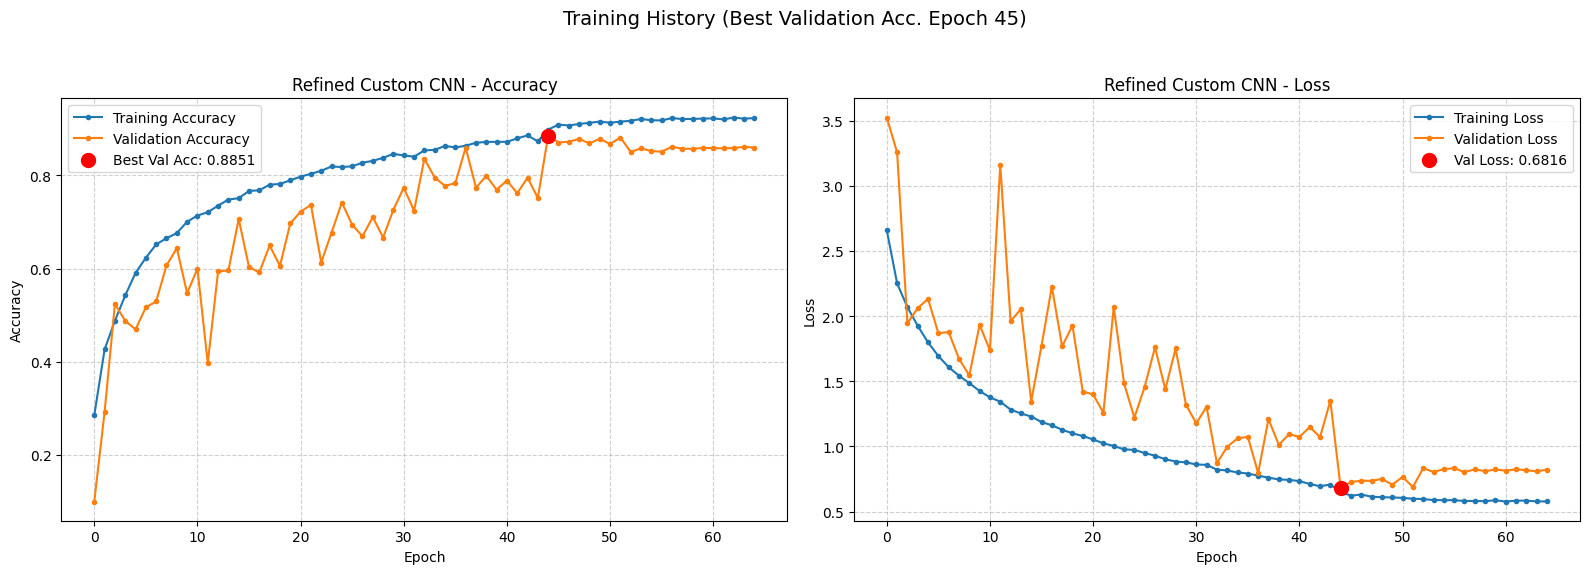

In [33]:
# --- Plot History ---
print("\n--- Plotting Training History ---")
plot_training_history(history, "Refined Custom CNN")


--- Evaluating Best Model on Test Set ---
Successfully loaded best model from: ../model/best_chunked_custom_cnn_model.keras


W0000 00:00:1745513284.766690  346419 loop_optimizer.cc:934] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/Refined_CNN_Genre_Classifier_1/FreqMask_1/cond/branch_executed/_62


Test Loss:     0.6351
Test Accuracy: 0.9016


W0000 00:00:1745513304.441050  346419 loop_optimizer.cc:934] Skipping loop optimization for Merge node with control input: Refined_CNN_Genre_Classifier_1/TimeMask_1/cond/branch_executed/_15


88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 243ms/step


W0000 00:00:1745513325.687084  346419 loop_optimizer.cc:934] Skipping loop optimization for Merge node with control input: Refined_CNN_Genre_Classifier_1/TimeMask_1/cond/branch_executed/_15



--- Confusion Matrix ---


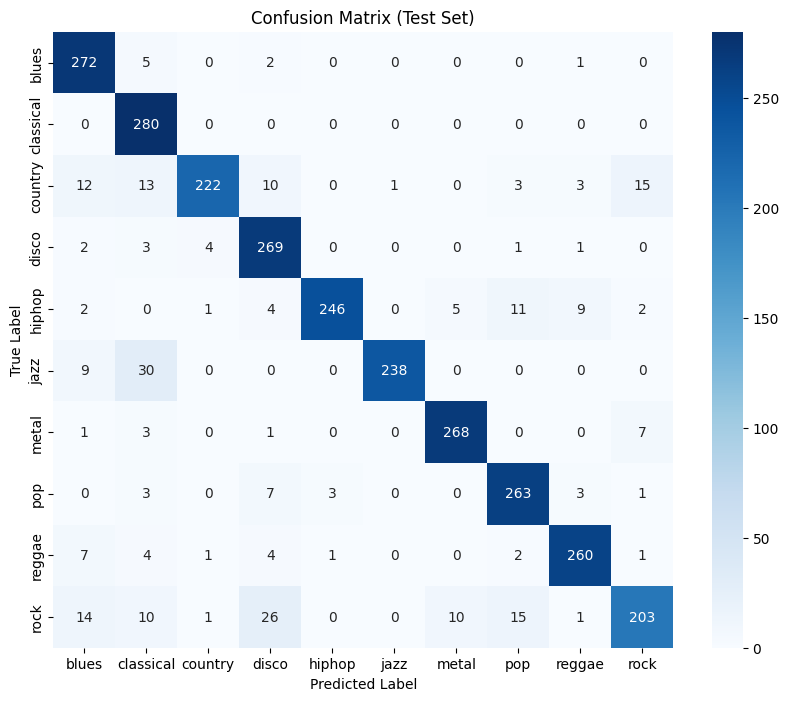


--- Classification Report ---
              precision    recall  f1-score   support

       blues     0.8527    0.9714    0.9082       280
   classical     0.7977    1.0000    0.8875       280
     country     0.9694    0.7957    0.8740       279
       disco     0.8328    0.9607    0.8922       280
      hiphop     0.9840    0.8786    0.9283       280
        jazz     0.9958    0.8592    0.9225       277
       metal     0.9470    0.9571    0.9520       280
         pop     0.8915    0.9393    0.9148       280
      reggae     0.9353    0.9286    0.9319       280
        rock     0.8865    0.7250    0.7976       280

    accuracy                         0.9016      2796
   macro avg     0.9093    0.9016    0.9009      2796
weighted avg     0.9092    0.9016    0.9009      2796



In [34]:
# --- Load Best Model and Evaluate on Test Set ---
print("\n--- Evaluating Best Model on Test Set ---")
best_model = None # Initialize
try:
    custom_objects = {"FrequencyMasking": FrequencyMasking, "TimeMasking": TimeMasking}
    best_model = models.load_model(BEST_MODEL_PATH, custom_objects=custom_objects)
    print(f"Successfully loaded best model from: {BEST_MODEL_PATH}")

    test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0, batch_size=BATCH_SIZE) # Use batch_size for eval too
    print(f"Test Loss:     {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # --- Generate Predictions for Reports ---
    y_pred_prob = best_model.predict(X_test, batch_size=BATCH_SIZE) # Use batch_size for predict too
    y_pred_classes = np.argmax(y_pred_prob, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # --- Confusion Matrix ---
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=GENRES, yticklabels=GENRES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    # --- Classification Report ---
    print("\n--- Classification Report ---")
    print(classification_report(y_true_classes, y_pred_classes, target_names=GENRES, digits=4))

except Exception as e:
    print(f"Error loading or evaluating best model: {e}")
    print("Evaluation could not be completed.")

In [35]:
# ## 9. Test Prediction on a Sample

In [36]:
def predict_single_genre(model_to_use, spectrogram_scaled, genres_list):
    """ Predicts genre from a single scaled spectrogram chunk. """
    if spectrogram_scaled.ndim == 3: # (height, width, channel)
        spectrogram_scaled = spectrogram_scaled[np.newaxis, ...] # Add batch dimension
    elif spectrogram_scaled.ndim != 4:
        raise ValueError(f"Input spectrogram has unexpected shape: {spectrogram_scaled.shape}")

    prediction = model_to_use.predict(spectrogram_scaled, verbose=0)[0] # Add verbose=0

    predicted_index = np.argmax(prediction)
    predicted_genre = genres_list[predicted_index]
    confidence_scores = {genre: float(score) for genre, score in zip(genres_list, prediction)}
    return predicted_genre, confidence_scores

In [37]:
# --- Load model if not already loaded ---
predictor_model = None
if 'best_model' in locals() and best_model is not None:
    predictor_model = best_model
    print("\nUsing best model loaded from evaluation section.")
else:
    try:
        custom_objects = {"FrequencyMasking": FrequencyMasking, "TimeMasking": TimeMasking}
        predictor_model = models.load_model(BEST_MODEL_PATH, custom_objects=custom_objects)
        print(f"\nLoaded best model from {BEST_MODEL_PATH} for prediction test.")
    except Exception as e:
        print(f"\nCould not load best model for prediction test: {e}")


Using best model loaded from evaluation section.


In [38]:
# --- Perform Prediction if Model Loaded ---
if predictor_model:
    print("\n--- Testing Prediction on Random Sample ---")
    # Select a random sample from the *scaled* test set
    sample_index = np.random.randint(0, len(X_test))
    sample_spectrogram_scaled = X_test[sample_index]
    true_genre_index = np.argmax(y_test[sample_index])
    true_genre = GENRES[true_genre_index]

    predicted_genre, confidence_scores = predict_single_genre(predictor_model, sample_spectrogram_scaled, GENRES)

    print(f"Sample Index: {sample_index}")
    print(f"True Genre:   {true_genre}")
    print(f"Predicted Genre: {predicted_genre}")
    print("\nConfidence Scores:")
    for genre, score in sorted(confidence_scores.items(), key=lambda item: item[1], reverse=True):
        print(f"  {genre:<10}: {score:.4f}")




--- Testing Prediction on Random Sample ---
Sample Index: 860
True Genre:   country
Predicted Genre: country

Confidence Scores:
  country   : 0.7246
  classical : 0.1963
  rock      : 0.0311
  blues     : 0.0268
  reggae    : 0.0112
  disco     : 0.0066
  jazz      : 0.0025
  pop       : 0.0004
  metal     : 0.0003
  hiphop    : 0.0001


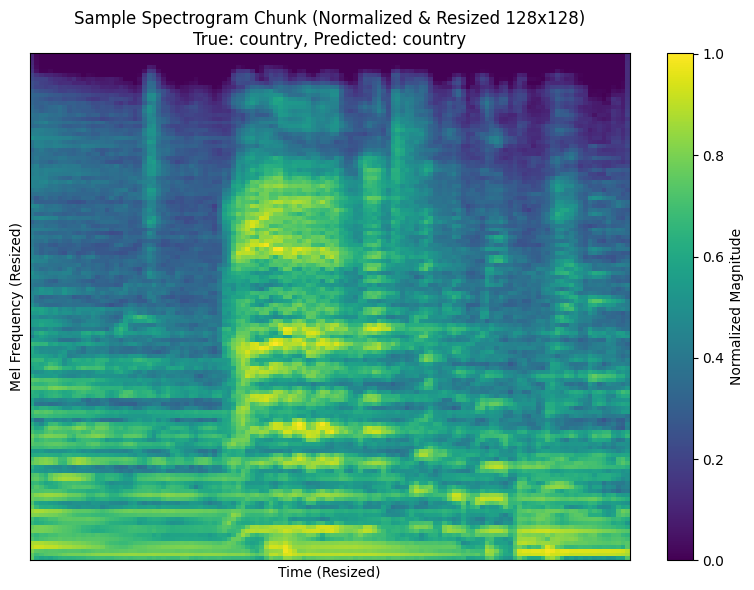


--- Notebook Execution Complete ---


In [40]:
if model is not None:  # Assuming there's a check for model loading
    # --- Plot the scaled spectrogram ---
    plt.figure(figsize=(8, 6)) # Adjusted size for square-ish plot
    display_spec = sample_spectrogram_scaled[:, :, 0] # Remove channel dim
    img = librosa.display.specshow(display_spec, cmap='viridis') # Basic display for resized
    plt.colorbar(img, label='Normalized Magnitude')
    plt.title(f"Sample Spectrogram Chunk (Normalized & Resized {RESIZE_DIM}x{RESIZE_DIM})\nTrue: {true_genre}, Predicted: {predicted_genre}")
    plt.xlabel("Time (Resized)")
    plt.ylabel("Mel Frequency (Resized)")
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping prediction test as model could not be loaded.")


print("\n--- Notebook Execution Complete ---")